# Notebook: SegFormer for Semantic Segmentation on CamVid

このノートブックでは、CamVidデータセットを使って、Hugging faceにあるSegFormerを使ったセグメンテーションを試します

ノートブック作成にあたり、下記を参考にさせて頂きました🤗

- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb
- https://github.com/huggingface/notebooks/blob/main/examples/semantic_segmentation.ipynb


# セットアップ
fine-tuneしたモデルを保存するgoogle driveをマウントします

Hugging faceのモジュール(Transformers, Datasets)をインストールします

In [29]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データセットのロード
以前、[SAMのfine-tuningを使ったセグメンテーションの検証](https://github.com/yh0sh/MyStudy/blob/main/SAM/Fine_tune_SAM_(segment_anything)_on_CamVid.ipynb)で作成したCamVidを修正した画像のデータセットをHugging faceのdatasetsに登録しました

https://huggingface.co/datasets/yh0sh/resized_camvid_annot_car

- オリジナルの画像とmaskデータを320\*480 => 256\*256へリサイズ
- maskデータはcarの領域は1、car以外の領域は0になるように加工

今回はこのデータセットを使用します

In [30]:
from datasets import load_dataset

dataset = load_dataset("yh0sh/resized_camvid_annot_car")

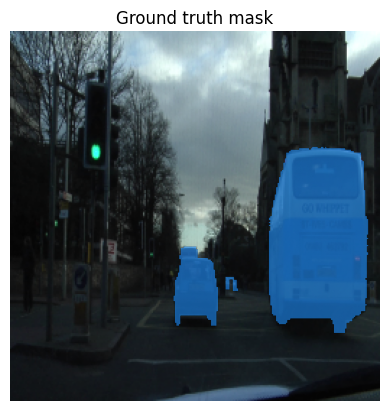

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

sample = dataset["train"][10]

# 画像データ
image = sample["image"]

# maskデータ
# NOTE maskデータはgrayscaleに変換後、最大値で割ることで{0, 1}の値域に標準化する
mask = np.array(sample["annot"].convert("L")).astype("float64")
mask /= np.nanmax(mask)

fig, axes = plt.subplots()
axes.imshow(np.array(image))
show_mask(np.array(mask), axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")
plt.show()

# PyTorch Datasetの作成
PyTorch Datasetのカスタムクラスを作ります

In [32]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):

    def __init__(self, dataset, feature_extractor, data_label):
        assert data_label in ["train", "validation", "test"]
        self.dataset = dataset[data_label]
        self.feature_extractor = feature_extractor
        self.data_label = data_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        image = self.dataset[idx]["image"]

        # NOTE maskデータはgrayscaleに変換後、最大値で割ることで{0, 1}の値域に標準化する
        mask = np.array(self.dataset[idx]["annot"].convert("L")).astype("float64")
        mask /= np.nanmax(mask)
        segmentation_map = mask

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map,
                                                return_tensors="pt")#, input_data_format="channels_last")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

# FeatureExtractorの読み込み
SegFormerのFeatureExtractorを読み込みます

In [33]:
from transformers import SegformerImageProcessor

feature_extractor = SegformerImageProcessor(do_reduce_labels=False) # 今回は2値分類なので do_reduce_labels = False とすることで、
                                                                    # unknownは除外せず、label = 0として使用

train_dataset = SemanticSegmentationDataset(dataset, feature_extractor, "train")
valid_dataset = SemanticSegmentationDataset(dataset, feature_extractor, "validation")
test_dataset = SemanticSegmentationDataset(dataset, feature_extractor, "test")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 360
Number of validation examples: 101
Number of testing examples: 223


# PyTorch DataLoaderの作成
先に作成したPyTorch Datasetを元にDataLoaderを作成します

pixel_values (4, 3, 512, 512)
labels (4, 512, 512)


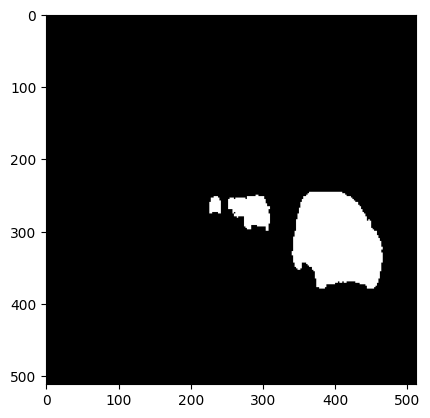

In [34]:
from torch.utils.data import DataLoader
from collections import Counter

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# SegFormerImageProcessorにより、256*256 => 512*512にリサイズ
for batch in train_dataloader:
    for k, v in batch.items():
        print (k, np.array(v).shape)

    # carにセグメントされたピクセルサイズの確認
    # label = 0 (= unknown)をmaskしてプロット
    mask = (batch["labels"] != 0)[0]

    plt.figure()
    plt.imshow(mask, cmap="gray")
    break

# Modelの読み込み

SegFormerの事前学習としてラベルリストを作成します

今回は、carのみセグメンテーションするため、二値データとして扱います

前処理として、以下を行いました(※)

 - 2値問題として扱い、label = 0 (unknown), 1 (car) とする
      - ADE20Kのラベルリストを使用する場合は、huggingfaceのdatasetsにある[label-files](https://huggingface.co/datasets/huggingface/label-files/blob/main/ade20k-id2label.json)をダウンロードする
 - 0: unknownは無視せず学習対象として扱う
      - [mean_iou](https://huggingface.co/spaces/evaluate-metric/mean_iou)を用いて評価する際、ignore_indexにunknownのラベルを指定することで評価から除外することが出来る
      - しかし、unknownを無視すると、carのラベルのついた領域(ground truth)内でしか評価しなくなるため、学習ではlossを正しく計算できなくなる
 - 0: unknownを255としない
      - do_reduce_labels = Trueとしない

※ 何度か値やパラメータを変えて実施した上での調査結果となりますが、解釈が間違っている可能性があります

誤解しているところがあれば、ご指摘頂けると助かります🙏

In [35]:
from transformers import SegformerForSemanticSegmentation

# NOTE: ADE20Kで使用されているlabelリストを使用する場合は、以下のコメントアウトを外す
#import json
#from huggingface_hub import cached_download, hf_hub_url, hf_hub_download
#
## load id2label mapping from a JSON on the hub
#repo_id = "huggingface/label-files"
#filename = "ade20k-id2label.json"
#id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
#id2label = {int(k): v for k, v in id2label.items()}
#label2id = {v: k for k, v in id2label.items()}

id2label = {0: "unknown", 1: "car"}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# モデル学習

In [36]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from collections import Counter

num_epochs = 100

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

# 学習結果を保存する
save_dir = "/content/drive/MyDrive/colab/SegFormer"   # 所望の場所に変更して下さい
losses_path = f"{save_dir}/loss_ft_segformer_camvid-b0.csv"
columns = ["epoch", "loss_train", "loss_eval"]
df_loss = pd.DataFrame([], columns=columns)
start_epoch = 0
best_loss = np.inf

# 途中から学習を再開する場合、保存したチェックポイントを読み込む
save_path = f"{save_dir}/fine_tune_segformer_camvid-b0.pth"
if os.path.exists(save_path):
    if device == "cpu":
        checkpoint = torch.load(save_path, map_location=torch.device("cpu"))
    else:
        checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint)

    df_loss = pd.read_csv(losses_path)
    start_epoch = df_loss["epoch"].values[-1] + 1
    best_loss = df_loss["loss_eval"].min()

for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
    print(f'## EPOCH: {epoch} best_loss_eval: {best_loss}')

    # 学習フェーズ
    model.train()
    epoch_losses = []

    print (f"train data {len(train_dataloader)}...")
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    loss_train = np.mean(epoch_losses)
    print(f'Mean loss (train): {loss_train}')

    # 評価フェーズ
    model.eval()
    with torch.no_grad():
        epoch_losses = []

        print (f"valid data {len(valid_dataloader)}...")
        for idx, batch in enumerate(tqdm(valid_dataloader)):
            # get the inputs;
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            epoch_losses.append(loss.item())

        loss_eval = np.mean(epoch_losses)
        print(f'Mean loss (valid): {loss_eval}')

        # 学習結果保存
        result = {
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_eval": loss_eval
        }
        df_loss = pd.concat([df_loss, pd.DataFrame([result])], axis=0)
        df_loss.to_csv(losses_path, index=False)

        # 評価値更新
        if np.mean(epoch_losses) < best_loss:
            best_loss = np.mean(epoch_losses)
            torch.save(model.state_dict(), save_path)
            print("Model saved!")


# 学習結果の可視化

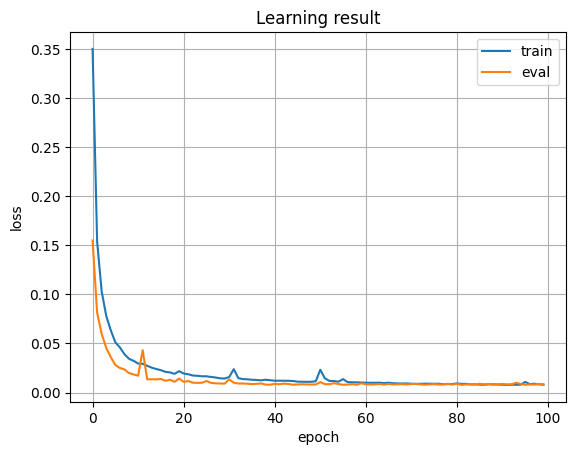

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_loss["epoch"], df_loss["loss_train"], label="train")
plt.plot(df_loss["epoch"], df_loss["loss_eval"], label="eval")
plt.title("Learning result")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.legend(loc="best")
plt.show()

epoch数が増えるに連れて損失は低下しており、学習は順調に行われたようです

# 推定結果
学習に使用したデータを使い、学習が正しく行われたか確認します

予測マスク値、正解マスク値を確認します

torch.Size([1, 2, 128, 128])


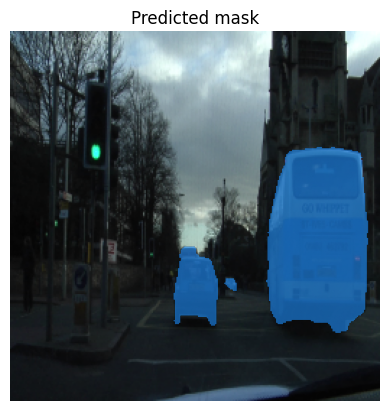

(-0.5, 255.5, 255.5, -0.5)

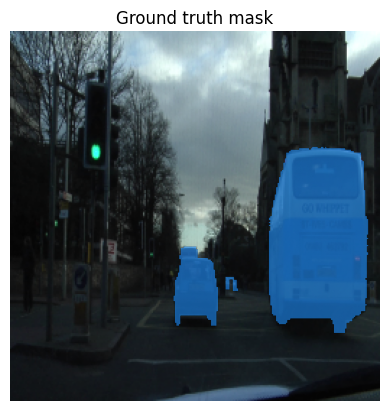

In [38]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

idx = 10
data = dataset["train"][idx]
image = data["image"]

mask = np.array(sample["annot"].convert("L")).astype("float64")
mask /= np.nanmax(mask)

encoded_inputs = feature_extractor(image, return_tensors="pt")#, input_data_format="channels_last")
pixel_values = encoded_inputs.pixel_values.to(device)

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

seg = upsampled_logits.argmax(dim=1)[0]

sf_seg = seg.detach().cpu().numpy()

fig, axes = plt.subplots()
axes.imshow(np.array(image))
show_mask(np.array(sf_seg), axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")
plt.show()

fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(mask)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

上記結果を元にIoUを計算します

In [39]:
import numpy as np

def calculate_iou(segmentation1, segmentation2):
    intersection = np.logical_and(segmentation1, segmentation2)
    union = np.logical_or(segmentation1, segmentation2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# IoUを計算
iou_score = calculate_iou(sf_seg.astype(bool), ground_truth_seg.astype(bool))
print(f"IoU: {iou_score}")

IoU: 0.966394779771615


次に使用したデータ全てのIoUを計算し、学習、評価、テストデータのIoU平均値をそれぞれ確認します

In [40]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

labels = ["train", "validation", "test"]
iou_scores_dict = {label: [] for label in labels}

iou_scores_path = "{save_dir}/iou_scores_{label}_ft_sf_camvid-b0.csv"
for label in labels:
    if os.path.exists(iou_scores_path.format(save_dir = save_dir, label = label)):
        continue

    print (f"###  {label}")
    for idx, inputs in tqdm(enumerate(dataset[label]), desc=f"{label} data {len(dataset[label])}"):

        image_id = inputs["image_id"]
        image = inputs["image"]

        mask = np.array(inputs["annot"].convert("L")).astype("float64")
        mask /= np.nanmax(mask)

        encoded_inputs = feature_extractor(image, return_tensors="pt")#, input_data_format="channels_last")
        pixel_values = encoded_inputs.pixel_values.to(device)

        model.eval()

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        # logits are of shape (batch_size, num_labels, height/4, width/4)
        logits = outputs.logits.cpu()

        # First, rescale logits to original image size
        upsampled_logits = nn.functional.interpolate(logits,
                        size=image.size[::-1], # (height, width)
                        mode='bilinear',
                        align_corners=False)

        seg = upsampled_logits.argmax(dim=1)[0]

        sf_seg = seg.detach().cpu().numpy()

        ground_truth_seg = np.array(mask)

        iou_score = calculate_iou(sf_seg.astype(bool), ground_truth_seg.astype(bool))
        iou_scores_dict[label].append([image_id, iou_score])
    print (f"mean: {np.nanmean(np.array(iou_scores_dict[label])[:,1].astype(float), axis=0)}")
    print (f"std: {np.nanstd(np.array(iou_scores_dict[label])[:,1].astype(float), axis=0)}")

    data = np.array(iou_scores_dict[label])
    pd.DataFrame(data).to_csv(iou_scores_path.format(save_dir = save_dir, label = label),
                              header=None, index=False)

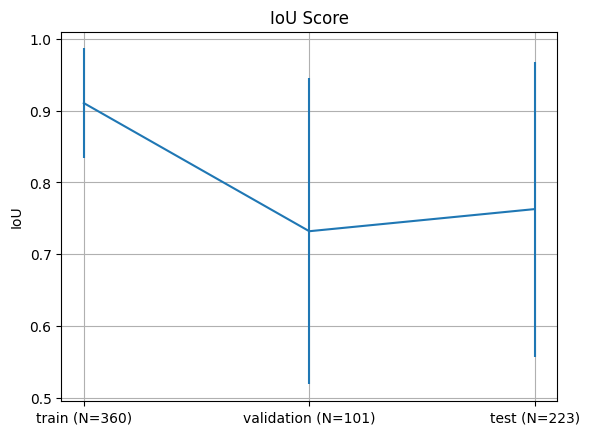

In [41]:
means = []
stds = []
nums = []
for label in labels:
    df = pd.read_csv(iou_scores_path.format(save_dir = save_dir, label = label), header=None)
    means.append(df.values[:,1].mean())
    stds.append(df.values[:,1].std())
    nums.append(df.values[:,1].size)

plt.figure()
plt.errorbar(np.arange(len(labels)), means, yerr=stds)
plt.xticks(np.arange(len(labels)), [f"{label} (N={num})" for label, num in zip(labels, nums)])
plt.ylabel("IoU")
plt.title("IoU Score")
plt.grid(True)

学習データは91%程度、評価とテストデータでは75%程度と中々の高精度となりました

これは [SAMをfine-tuningした結果](https://github.com/yh0sh/MyStudy/blob/main/SAM/Fine_tune_SAM_(segment_anything)_on_CamVid.ipynb)に比べて、評価とテストデータは3-5%程度低い平均値となっています

また、標準偏差は5%程度大きくなっており、データ単位での精度の差が大きくなっています

最高と最低のIoUスコアとなった画像を出力して、入力画像の特徴や傾向を目視確認して精度への影響を確認します

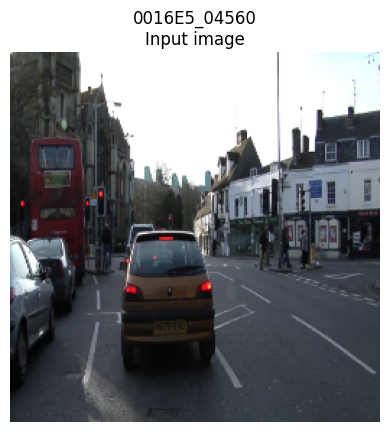

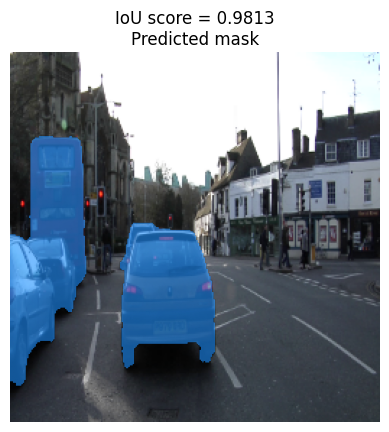

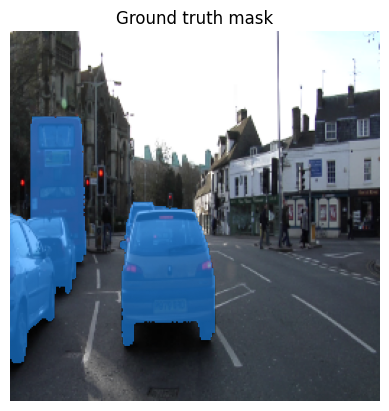

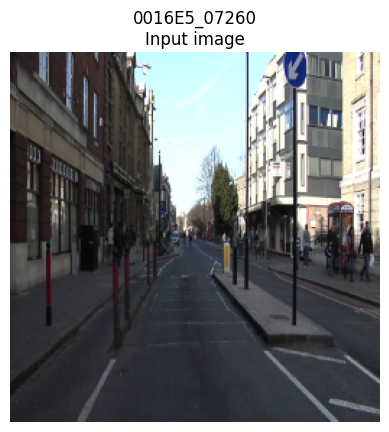

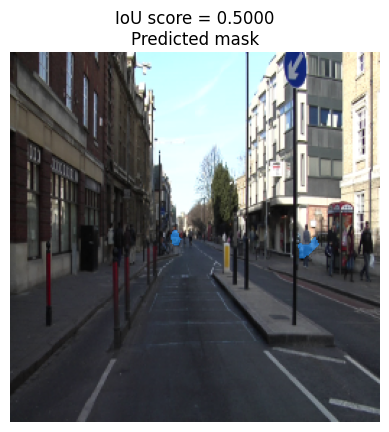

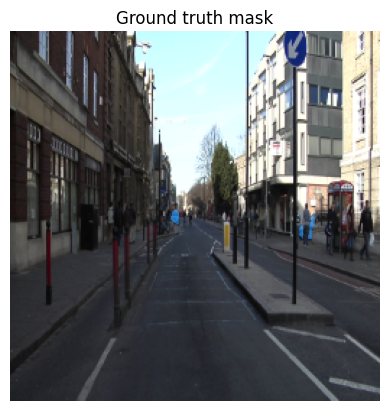

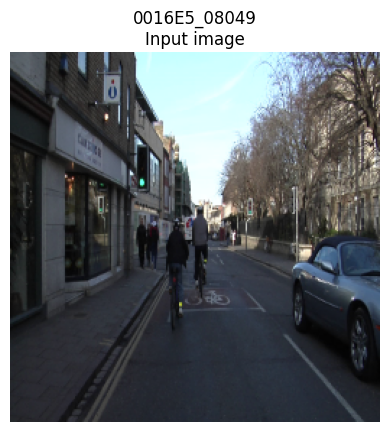

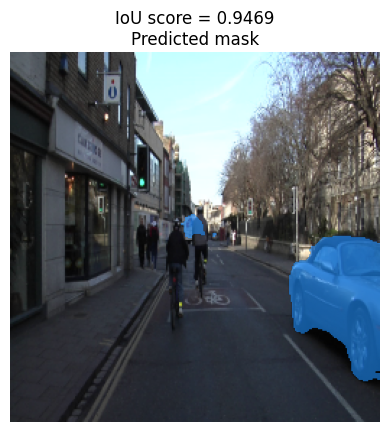

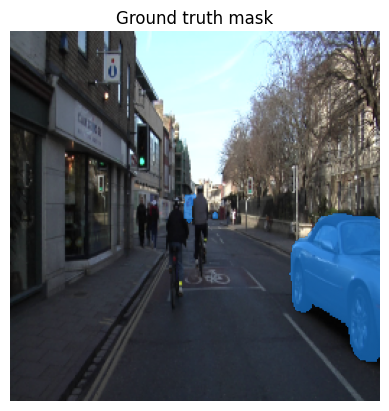

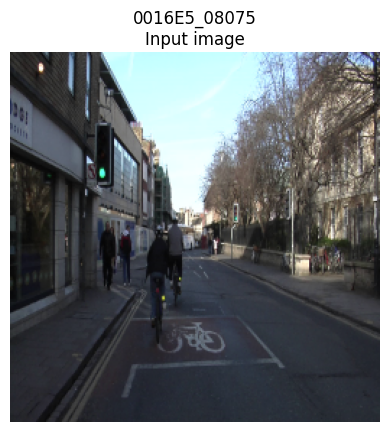

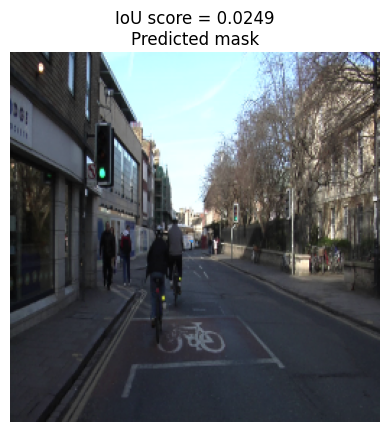

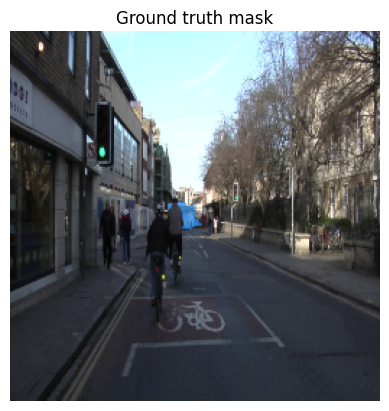

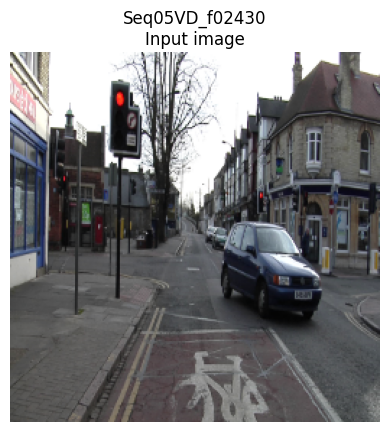

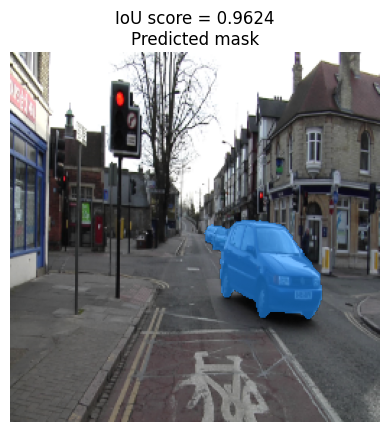

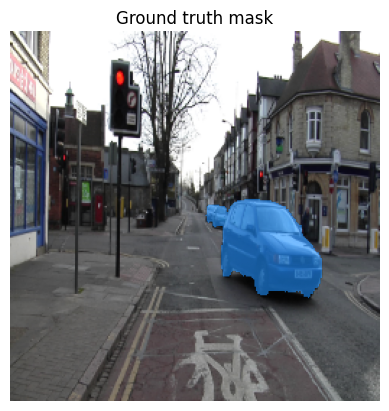

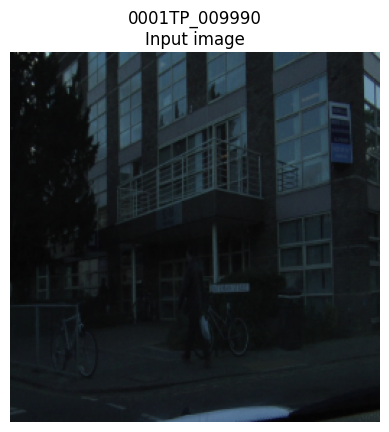

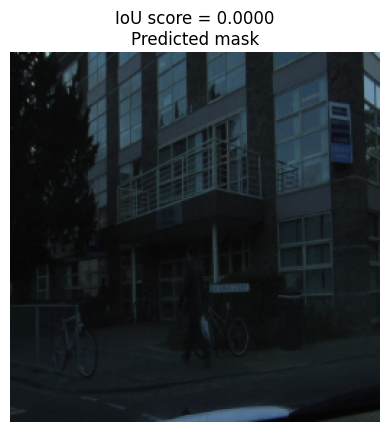

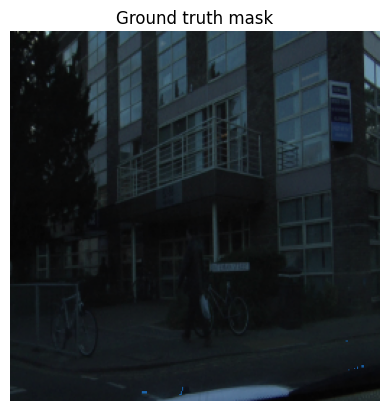

In [ ]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

from collections import Counter

for label in labels:
    df = pd.read_csv(iou_scores_path.format(save_dir = save_dir, label = label), header=None)
    image_ids = df.values[:,0]
    iou_scores = df.values[:,1]

    max_score_idx = np.argmax(iou_scores)
    min_score_idx = np.argmin(iou_scores)

    ds_dict = {inputs["image_id"]: inputs for inputs in dataset[label]}
    for score_idx in [max_score_idx, min_score_idx]:
        iou_score = iou_scores[score_idx]
        image_id = image_ids[score_idx]

        inputs = ds_dict[image_id]

        image = inputs["image"]

        mask = np.array(inputs["annot"].convert("L")).astype("float64")
        mask /= np.nanmax(mask)

        encoded_inputs = feature_extractor(image, return_tensors="pt")#, input_data_format="channels_last")
        pixel_values = encoded_inputs.pixel_values.to(device)

        model.eval()

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)

        # logits are of shape (batch_size, num_labels, height/4, width/4)
        logits = outputs.logits.cpu()

        # First, rescale logits to original image size
        upsampled_logits = nn.functional.interpolate(logits,
                        size=image.size[::-1], # (height, width)
                        mode='bilinear',
                        align_corners=False)

        seg = upsampled_logits.argmax(dim=1)[0]

        sf_seg = seg.detach().cpu().numpy()

        ground_truth_seg = np.array(mask)

        plt.figure()
        plt.imshow(image)
        plt.title(f"{image_id}\nInput image")
        plt.axis('off')

        fig, axes = plt.subplots()
        axes.imshow(image)
        show_mask(sf_seg, axes)
        axes.title.set_text(f"IoU score = {iou_score:6.4f}\nPredicted mask")
        axes.axis("off")

        fig, axes = plt.subplots()
        axes.imshow(image)
        ground_truth_seg = np.array(mask)
        show_mask(ground_truth_seg, axes)
        axes.title.set_text(f"Ground truth mask")
        axes.axis("off")

IoUが低い画像を見てみると、carの領域が小さい場合、セグメンテーションが上手くいっていかないようです

このIoUの低い画像の傾向は [SAMをfine-tuningした場合の検証](https://github.com/yh0sh/MyStudy/blob/main/SAM/Fine_tune_SAM_(segment_anything)_on_CamVid.ipynb)と同様です

精度を上げるためには、carの領域が小さい学習データを増やすことを考えると良さそうです

# まとめ

CamVidデータセットを使用し、Hugging FaceのSegFormerを用いたセグメンテーションを試しました

- 前処理として、画像を256x256にリサイズ、maskデータについてはcarの領域を1、それ以外を0と値を変える加工を行いました
    - このデータセットはHugging Faceのdatasetsに登録しており、誰でもダウンロードして利用できます

- 事前学習としてラベルリストを作成しました。
今回は「car」のみをセグメンテーションするため、二値データとして扱いました。

- fine-tuningしたSegFormerモデルを用いると学習データは91%程度、評価とテストデータでは75%程度と高精度なIoUとなりました。

   - 前回fine-tuningしたSAMモデルに比べて、評価とテストデータは3-5%程度、低い平均値となっています。
